In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


transactions_df = dict(np.load('./DataSets/transactions.npz'))
data = {k: [s.decode("utf-8") for s in v.tobytes().split(b"\x00")] if v.dtype == np.uint8 else v for k, v in transactions_df.items()}


transactions_df = pd.DataFrame.from_dict(data)
loyers_df = pd.read_csv('./DataSets/loyers.csv')
taux_interet = pd.read_csv('./DataSets/taux_interet.csv')
parc_imo_df = pd.read_csv('./DataSets/parc_immobilier.csv')



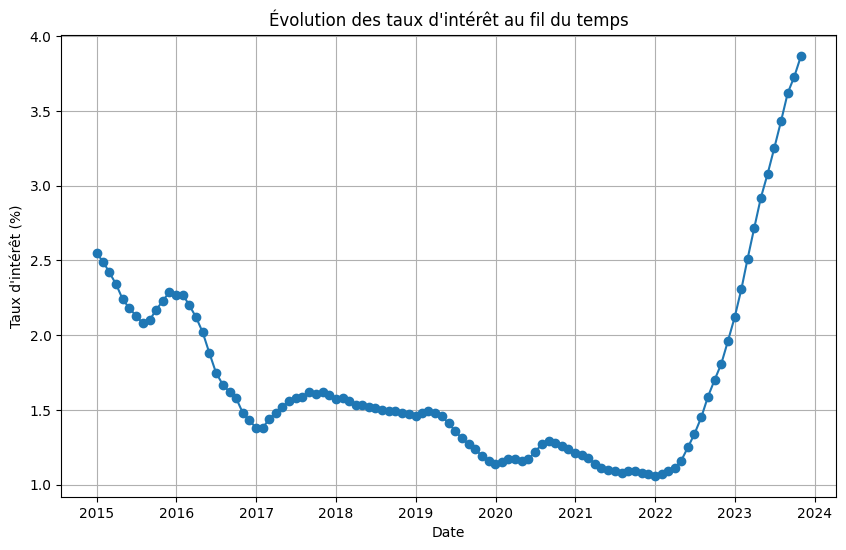

In [53]:
# Évolution des taux d'intérêt au fil du temps
taux_interet['date'] = pd.to_datetime(taux_interet['date'])
taux_interet = taux_interet.sort_values('date')

plt.figure(figsize=(10, 6))
plt.plot(taux_interet['date'], taux_interet['taux'], marker='o')
plt.title("Évolution des taux d'intérêt au fil du temps")
plt.xlabel("Date")
plt.ylabel("Taux d'intérêt (%)")
plt.grid(True)
plt.show()

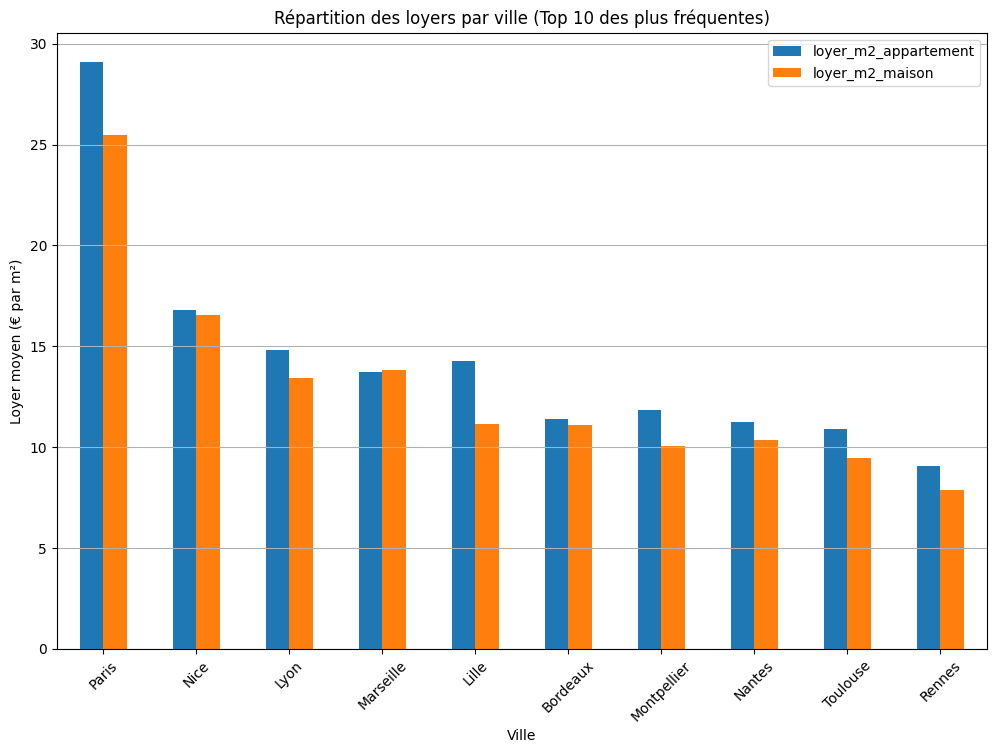

In [54]:
top_cities = [
    'Paris', 'Lyon', 'Marseille', 'Toulouse', 'Nice', 'Nantes', 'Montpellier', 'Bordeaux', 'Lille', 'Rennes', 
]

loyers_df['ville_simplified'] = loyers_df['ville'].str.extract(r'([A-Za-z]+)', expand=False).str.capitalize()

top_loyers_cities = loyers_df[loyers_df['ville_simplified'].isin(top_cities)]

top_loyers_cities_mean = top_loyers_cities.groupby('ville_simplified')[['loyer_m2_appartement', 'loyer_m2_maison']].mean()

top_loyers_cities_mean['mean_rent'] = top_loyers_cities_mean.mean(axis=1)
top_loyers_cities_mean = top_loyers_cities_mean.sort_values(by='mean_rent', ascending=False)

top_loyers_cities_mean[['loyer_m2_appartement', 'loyer_m2_maison']].plot(kind='bar', figsize=(12, 8))
plt.title("Répartition des loyers par ville (Top 10 des plus fréquentes)")
plt.xlabel("Ville")
plt.ylabel("Loyer moyen (€ par m²)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

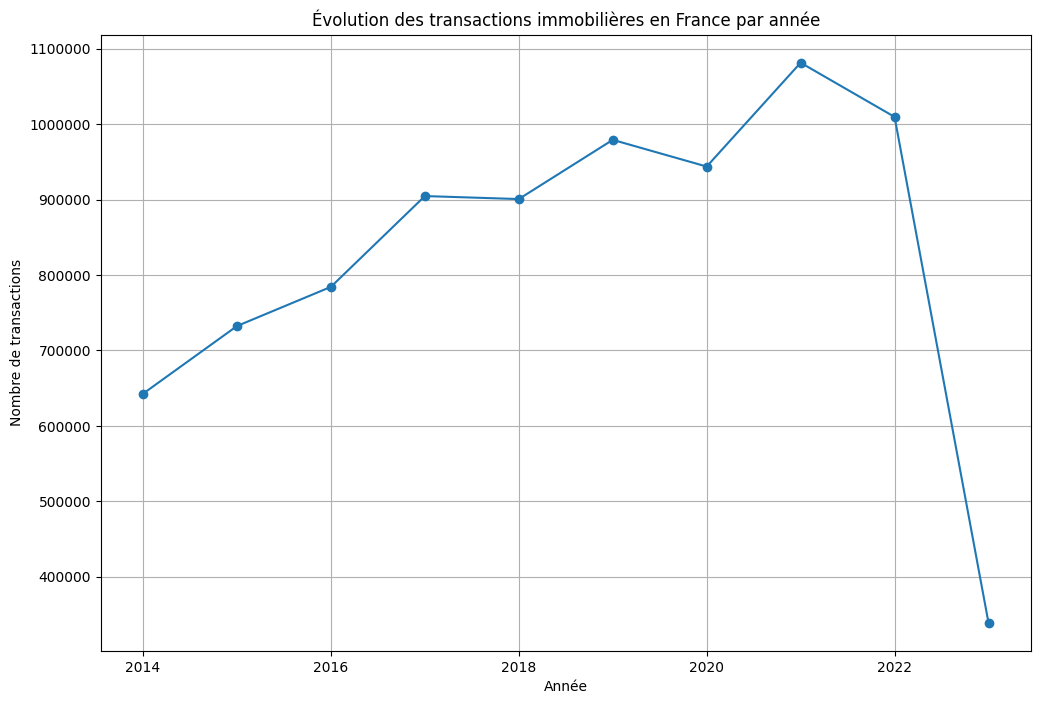

In [55]:
transactions_df['date_transaction'] = pd.to_datetime(transactions_df['date_transaction'])

transactions_df['year'] = transactions_df['date_transaction'].dt.year

transactions_per_year = transactions_df.groupby('year').size()

plt.figure(figsize=(12, 8))
transactions_per_year.plot(kind='line', marker='o')
plt.title("Évolution des transactions immobilières en France par année")
plt.xlabel("Année")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')  
plt.show()


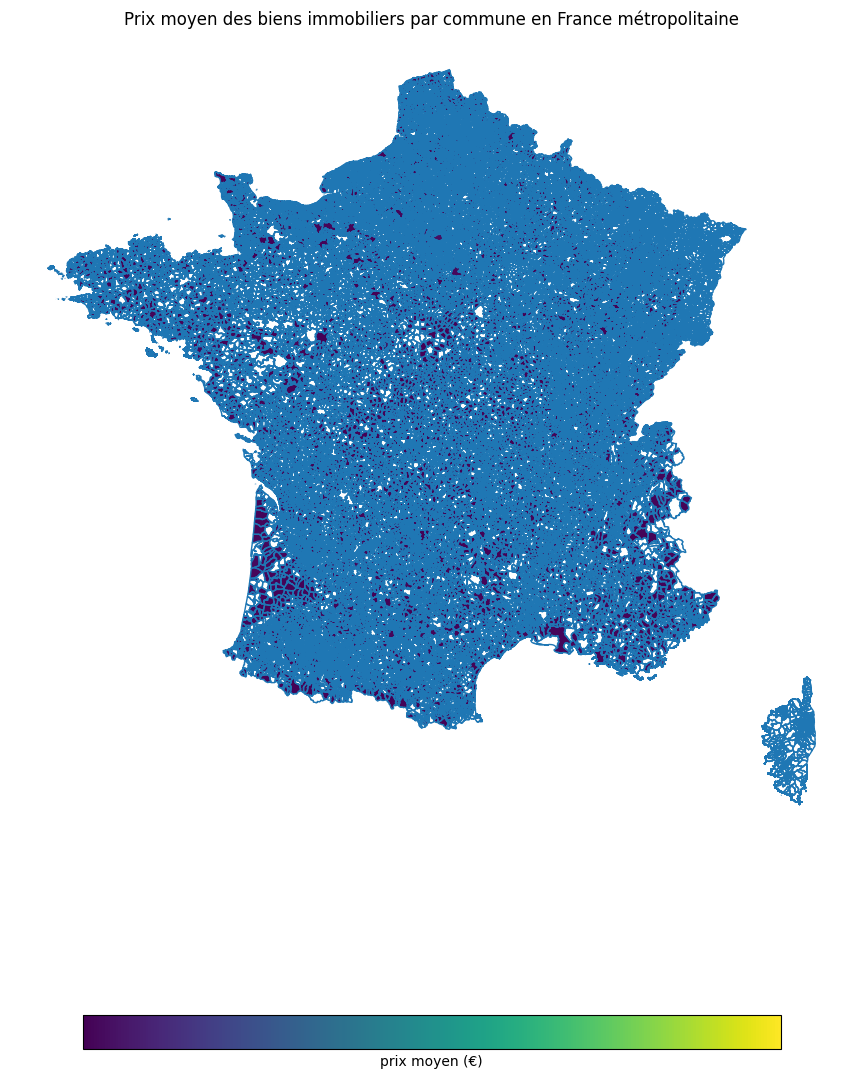

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming transactions_df is already defined
transactions_df['ville'] = transactions_df['ville'].str.lower()

def consolidate_arrondissements(city_name):
    return city_name.split()[0] if city_name.startswith(('paris', 'marseille', 'lyon')) else city_name

transactions_df['ville'] = transactions_df['ville'].apply(consolidate_arrondissements)

average_price = transactions_df.groupby('ville')['prix'].mean().reset_index()
average_price.columns = ['nom', 'avg_price']

shapefile_path = './DataSets/france/communes-20220101.shp'
communes = gpd.read_file(shapefile_path)

communes['nom'] = communes['nom'].str.lower()

communes = communes.merge(average_price, on='nom', how='left')

metropolitan_insee_prefixes = [str(i).zfill(2) for i in range(1, 96)] + ['2A', '2B']
communes = communes[communes['insee'].str[:2].isin(metropolitan_insee_prefixes)]

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
communes.boundary.plot(ax=ax, linewidth=1)
communes.plot(column='avg_price', ax=ax, legend=True,
              legend_kwds={'label': "prix moyen (€)",
                           'orientation': "horizontal",
                           'shrink': 0.6, 
                           'spacing': 'uniform',  
                           'extend': 'neither', 
                           'extendfrac': 0, 
                           'ticks': [0, 1, 2, 3, 4, 5, 6], 
                           'format': '%.0f',
                           }, 
              cmap='viridis',
              missing_kwds={
                  "color": "white",
                  "label": "Pas de données"
              })
ax.set_title('Prix moyen des biens immobiliers par commune en France métropolitaine')
ax.set_axis_off()

plt.show()



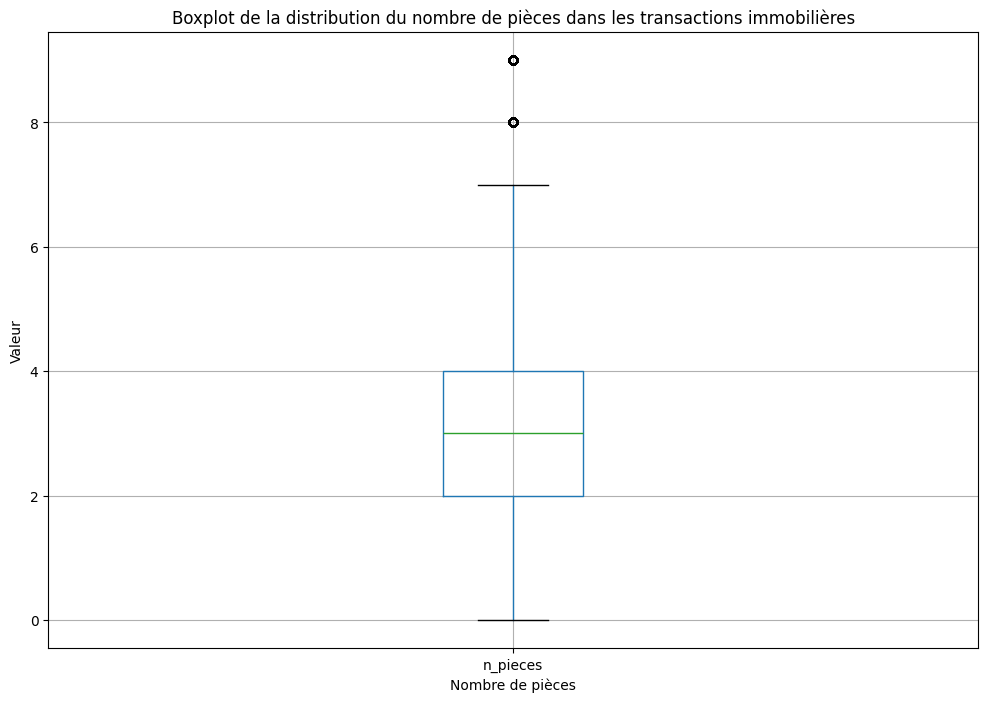

In [61]:

transactions_df['date_transaction'] = pd.to_datetime(transactions_df['date_transaction'])

filtered_transactions = transactions_df[transactions_df['n_pieces'] < 10]

# Créer le boxplot
plt.figure(figsize=(12, 8))
filtered_transactions.boxplot(column='n_pieces')
plt.title("Boxplot de la distribution du nombre de pièces dans les transactions immobilières")
plt.xlabel("Nombre de pièces")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()

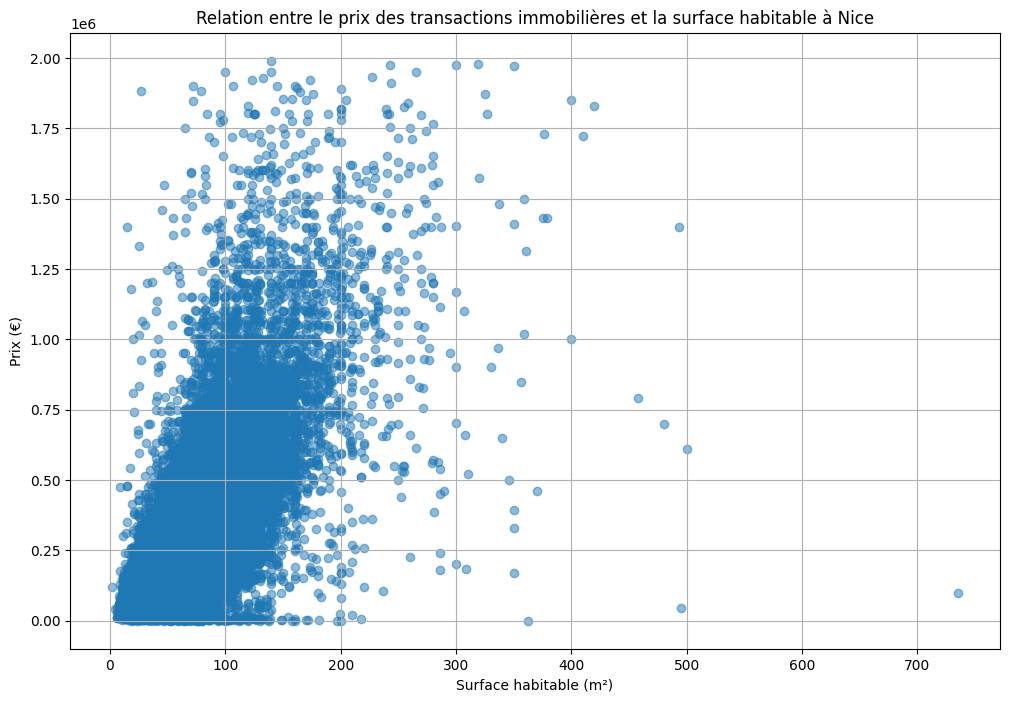

In [62]:
filtered_transactions = transactions_df[(transactions_df['prix'] < 2000000) & (transactions_df['ville'] == "nice")]

plt.figure(figsize=(12, 8))
plt.scatter(filtered_transactions['surface_habitable'], filtered_transactions['prix'], alpha=0.5)
plt.title("Relation entre le prix des transactions immobilières et la surface habitable à Nice")
plt.xlabel("Surface habitable (m²)")
plt.ylabel("Prix (€)")
plt.grid(True)
plt.show()

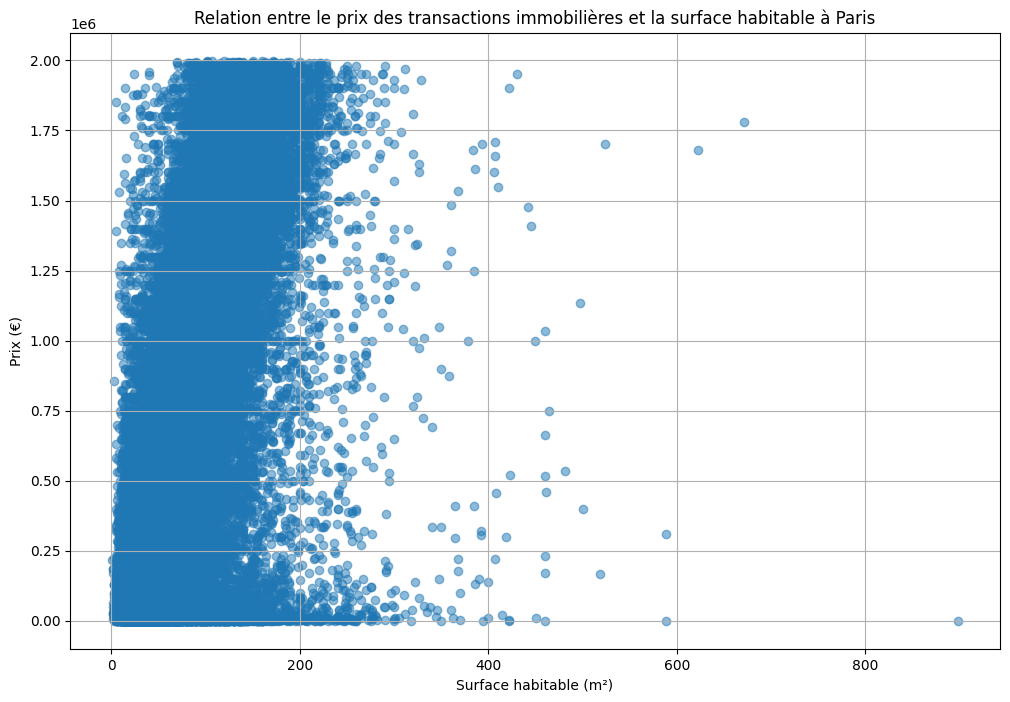

In [63]:
def consolidate_arrondissements(city_name):
    return city_name.split()[0] if city_name.startswith(('paris')) else  city_name

transactions_df['ville'] = transactions_df['ville'].apply(consolidate_arrondissements)

filtered_transactions = transactions_df[(transactions_df['prix'] < 2000000) & (transactions_df['ville'] == "paris")]

plt.figure(figsize=(12, 8))
plt.scatter(filtered_transactions['surface_habitable'], filtered_transactions['prix'], alpha=0.5)
plt.title("Relation entre le prix des transactions immobilières et la surface habitable à Paris")
plt.xlabel("Surface habitable (m²)")
plt.ylabel("Prix (€)")
plt.grid(True)
plt.show()

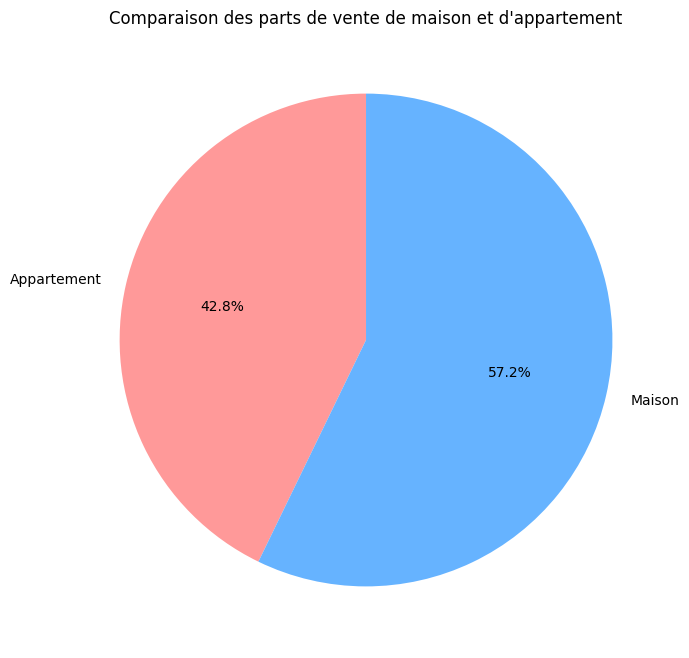

In [66]:

sales_summary = transactions_df.groupby('type_batiment')['prix'].sum()

plt.figure(figsize=(8, 8))
sales_summary.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.ylabel('')
plt.title('Comparaison des parts de vente de maison et d\'appartement')

plt.show()

/var/folders/pf/1d7dglm12jg17y01nf2_r6kw0000gn/T/ipykernel_69807/1211719183.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parc_imo_df_2020['ville'] = parc_imo_df_2020['ville'].apply(consolidate_arrondissements)


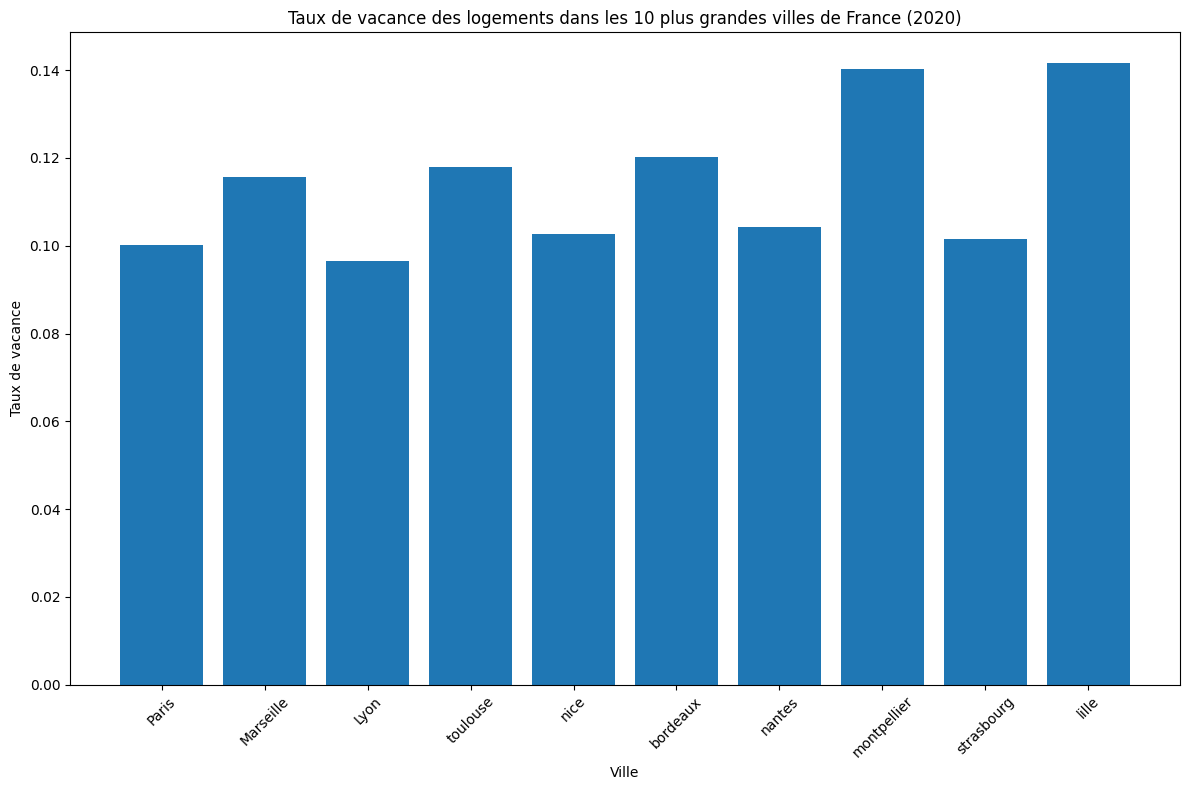

In [76]:
parc_imo_df_2020 = parc_imo_df[parc_imo_df['date'] == 2020]


def consolidate_arrondissements(city_name):
    city_name = city_name.lower() 
    if city_name.startswith(('paris', 'marseille', 'lyon')):
        return city_name.split()[0].capitalize()
    return city_name

parc_imo_df_2020['ville'] = parc_imo_df_2020['ville'].apply(consolidate_arrondissements)

data_2020_aggregated = parc_imo_df_2020.groupby('ville').agg({
    'n_logements': 'sum',
    'n_logements_vacants': 'sum'
}).reset_index()

data_2020_aggregated['taux_vacance'] = data_2020_aggregated['n_logements_vacants'] / data_2020_aggregated['n_logements']

top_10_villes_2020 = data_2020_aggregated.nlargest(10, 'n_logements')

plt.figure(figsize=(12, 8))
plt.bar(top_10_villes_2020['ville'], top_10_villes_2020['taux_vacance'])
plt.xlabel('Ville')
plt.ylabel('Taux de vacance')
plt.title('Taux de vacance des logements dans les 10 plus grandes villes de France (2020)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()